# 📊 Tutorial: Evaluación Unificada de Modelos Sustitutos

Este notebook demuestra el flujo completo de **tuning** y **evaluación** de modelos sustitutos,
mostrando cómo la estructura de métricas es **compatible** entre:

1. **Datos reales** (datasets de productividad de insectos)
2. **Benchmarks sintéticos** (funciones de prueba estándar)

---

## 📋 Contenido

1. [Configuración inicial](#1-configuración-inicial)
2. [Carga de datos reales](#2-carga-de-datos-reales)
3. [Nested LODO Tuning](#3-nested-lodo-tuning)
4. [Análisis de resultados](#4-análisis-de-resultados)
5. [Evaluación con Benchmarks](#5-evaluación-con-benchmarks)
6. [Métodos de evaluación en Benchmarks](#6-métodos-de-evaluación-en-benchmarks)
7. [Comparación unificada](#7-comparación-unificada)

## 1. Configuración inicial

Importamos los módulos necesarios del proyecto.

In [1]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Modelos sustitutos
from src.models.gp import GPSurrogateRegressor
from src.models.ridge import RidgeSurrogateRegressor
from src.models.pls import PLSSurrogateRegressor
from src.models.dummy import DummySurrogateRegressor

# Análisis y tuning
from src.analysis.tuning import nested_lodo_tuning
from src.analysis.tuning_reporter import ResultsLoader, ModelReconstructor
from src.analysis.metrics import evaluate_model, make_splits
from src.analysis.surrogate_metrics import compute_surrogate_metrics, SurrogateMetrics
from src.utils.paths import TESTS_DIR

# Benchmarks
from src.benchmarks import (
    generate_benchmark_dataset,
    list_benchmarks,
)
from src.analysis.benchmark_runner import (
    evaluate_model_on_dataset,      # Método 1: Train/Test simple
    evaluate_model_with_lodo,       # Método 2: LODO CV
    nested_lodo_tuning_benchmark,   # Método 3: Nested LODO Tuning
    run_quick_benchmark,
)

# Configuraciones
from test_tuning_specs import *

print("✅ Módulos cargados correctamente")

✅ Módulos cargados correctamente


## 2. Carga de datos reales

Cargamos el dataset de **productividad de Hermetia illucens** (mosca soldado negra).

Este dataset contiene:
- **Features**: Composición de la dieta (nutrientes)
- **Targets**: Métricas de productividad (FCR, proteína, etc.)
- **Groups**: Identificador de dieta (para Leave-One-Diet-Out CV)

In [2]:
# Cargar dataset
DATA_PATH = "../data/entomotive_datasets/productivity_hermetia_lote.csv"

df = pd.read_csv(DATA_PATH)
print(f"📁 Dataset cargado: {df.shape[0]} muestras, {df.shape[1]} columnas")
print(f"\n📊 Primeras filas:")
df.head()

📁 Dataset cargado: 33 muestras, 43 columnas

📊 Primeras filas:


,species,study_block,diet_name,Dieta,Tratamiento,Replica,byproduct_type,inclusion_pct,water_condition,processing,...,Peso total del sustrato (g) al finalizar el periodo de alimentación,PROTEINA (%),GRASA (%),QUITINA (%),CENIZAS (%),CARBOHIDRATOS (%),TPC_dieta_media__dup1,TPC_dieta_sd__dup1,TPC_larva_media__dup1,TPC_larva_sd__dup1
0,Hermetia,main,Control,Control,0,1,control,0,none,none,...,1884.437753,32.298228,7.856994,4.536508,24.085233,31.223037,0.180416,0.012046,0.432843,0.031135
1,Hermetia,main,Control,Control,0,2,control,0,none,none,...,1391.567280,31.988273,9.178856,3.188548,23.805322,31.839000,0.180416,0.012046,0.432843,0.031135
2,Hermetia,main,Control,Control,0,3,control,0,none,none,...,1334.673548,31.522017,17.458388,4.024695,22.767007,24.227893,0.180416,0.012046,0.432843,0.031135
3,Hermetia,main,Hoja15,Hoja15,1,1,hoja,15,none,none,...,1330.567333,32.439877,8.138716,10.804604,25.394843,23.221962,0.903410,0.100583,0.358376,0.017351
4,Hermetia,main,Hoja15,Hoja15,1,2,hoja,15,none,none,...,1069.702232,31.861333,9.794866,7.392563,26.810799,24.140439,0.903410,0.100583,0.358376,0.017351


In [3]:

from typing import List


def build_X_y_groups(df: pd.DataFrame, target_col: str, feature_cols: List[str]):
    """
    Prepares the data matrices X, y and groups.
    Auto-detects categorical columns (like Byproduct type) and one-hot encodes them,
    merging them with the selected numeric feature_cols.
    """
    data = df.copy()
    data = data.loc[~data[target_col].isna()].reset_index(drop=True)

    groups = data["diet_name"].astype(str).to_numpy()
    y = data[target_col].astype(float).to_numpy()

    # Handle Byproduct Type (Categorical) - Always added as it's structural
    if "byproduct_type" in data.columns:
        byp = pd.get_dummies(data["byproduct_type"], prefix="byproduct", drop_first=False)
    else:
        byp = pd.DataFrame()

    # numeric features
    Xdf = data[feature_cols].copy()

    # Concatenate numeric features + dummies
    if not byp.empty:
        Xdf = pd.concat([Xdf, byp], axis=1)

    Xdf = Xdf.apply(pd.to_numeric, errors="coerce")
    Xdf = Xdf.fillna(Xdf.median(numeric_only=True))

    X = Xdf.to_numpy(dtype=float)
    return X, y, groups, Xdf.columns.tolist()

In [4]:
# Definir columnas
# Ajusta estos nombres según tu dataset real
TARGET_COL = TARGET_MAP["FCR"]  # Feed Conversion Ratio

In [5]:
X, y, groups, feature_names = build_X_y_groups(df, TARGET_COL, FEATURE_COLS_FULL)

In [6]:
print(f"🎯 Target: {TARGET_COL}")
print(f"👥 Grupos: {groups} ({len(groups)} grupos únicos)")
print(f"📐 Features ({len(FEATURE_COLS_FULL)}): {FEATURE_COLS_FULL[:5]}...")

🎯 Target: FCR
👥 Grupos: ['Control' 'Control' 'Control' 'Hoja15' 'Hoja15' 'Hoja15' 'Hoja30'
 'Hoja30' 'Hoja30' 'Hoja50' 'Hoja50' 'Orujo30' 'Orujo30' 'Orujo30'
 'Orujo50' 'Orujo50' 'Orujo50' 'Orujo70' 'Orujo70' 'Orujo70' 'Orujo90'
 'Orujo90' 'Quinoa15' 'Quinoa15' 'Quinoa15' 'Quinoa30' 'Quinoa30'
 'Quinoa30' 'Quinoa50' 'Quinoa50' 'Quinoa50'] (31 grupos únicos)
📐 Features (10): ['inclusion_pct', 'Proteína (%)_media', 'Grasa (%)_media', 'Fibra (%)_media', 'Cenizas (%)_media']...


In [7]:

# Verificar NaNs
print(f"❓ NaNs en X: {np.isnan(X).sum()}")
print(f"❓ NaNs en y: {np.isnan(y).sum()}")

# Estadísticas básicas del target
print(f"\n📈 Estadísticas de {TARGET_COL}:")
print(f"   Media: {y.mean():.4f}")
print(f"   Std: {y.std():.4f}")
print(f"   Rango: [{y.min():.4f}, {y.max():.4f}]")

❓ NaNs en X: 0
❓ NaNs en y: 0

📈 Estadísticas de FCR:
   Media: 1.8278
   Std: 0.3045
   Rango: [1.3714, 2.6519]


## 3. Nested LODO Tuning

El **Nested Leave-One-Diet-Out (LODO)** es nuestra estrategia de validación cruzada:

```
┌─────────────────────────────────────────────────────────────┐
│                    NESTED LODO CV                           │
├─────────────────────────────────────────────────────────────┤
│  Outer Loop: Para cada dieta d                              │
│    ├── Test set: dieta d                                    │
│    ├── Train set: todas las demás dietas                    │
│    │                                                        │
│    └── Inner Loop: Tuning con el train set                  │
│          ├── Para cada combinación de hiperparámetros       │
│          │     └── Inner LODO CV (dietas en train)          │
│          └── Seleccionar mejores params                     │
│                                                             │
│    Entrenar con mejores params → Evaluar en Test (dieta d)  │
└─────────────────────────────────────────────────────────────┘
```

### 3.1 Definir grilla de hiperparámetros

In [8]:
# Grilla simplificada para demostración (usa TUNING_SPECS para completa)
param_grid_demo = get_param_grids(n_features=X.shape[1])



print("🔧 Grilla de hiperparámetros (demo):")
for k, v in param_grid_demo.items():
    print(f"   {k}: {v}")

# Total de combinaciones
n_combos = np.prod([len(v) for v in param_grid_demo.values()])
print(f"\n📊 Total combinaciones: {n_combos}")

🔧 Grilla de hiperparámetros (demo):
   Dummy: {'strategy': ['mean', 'median']}
   Ridge: {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0], 'fit_intercept': [True]}
   PLS: {'n_components': [1, 2, 3, 4, 5, 6, 7], 'scale': [True]}
   GP: {'alpha': [0.01], 'n_restarts_optimizer': [15], 'normalize_y': [True], 'kernel': [RBF(length_scale=1) + WhiteKernel(noise_level=0.0001)]}

📊 Total combinaciones: 16


### 3.2 Ejecutar Nested LODO Tuning

Ejecutamos el tuning para el modelo GP (Gaussian Process).

In [9]:
model_name = "gp_demo"
output_dir = TESTS_DIR/ "notebook_04_unified_evaluation_tutorial/" / model_name / "productivity_hermetia_lote" / "unified_evaluation_demo"


In [12]:
from run_exhaustive_tuning import run_tuning_session

run_tuning_session(
    session_name="unified_evaluation_demo",
    feature_cols= FEATURE_COLS_FULL,
    base_output_dir=output_dir
)

2026-01-18 14:46:45,140 | INFO | >>> STARTING TARGET: FCR (FCR)
2026-01-18 14:46:45,147 | INFO | Data Shape: Samples=31 | Total Features (with dummies)=14
2026-01-18 14:46:45,148 | INFO | --- Tuning Dummy (Grid Size: 2) ---



STARTING SESSION: unified_evaluation_demo
Output Directory: C:\Users\maria\Downloads\Jose_lenovo\TFG\surrogate_models\outputs\tests\notebook_04_unified_evaluation_tutorial\gp_demo\productivity_hermetia_lote\unified_evaluation_demo\unified_evaluation_demo
Features (10): ['inclusion_pct', 'Proteína (%)_media', 'Grasa (%)_media', 'Fibra (%)_media', 'Cenizas (%)_media', 'Carbohidratos (%)_media', 'ratio_P_C', 'ratio_P_F', 'ratio_Fibra_Grasa', 'TPC_dieta_media']



2026-01-18 14:46:46,772 | INFO |     [DONE] Dummy -> MAE: 0.2908 | Coverage95: N/A
2026-01-18 14:46:46,773 | INFO | --- Tuning Ridge (Grid Size: 5) ---
2026-01-18 14:46:47,195 | INFO |     [DONE] Ridge -> MAE: 0.2394 | Coverage95: N/A
2026-01-18 14:46:47,197 | INFO | --- Tuning PLS (Grid Size: 7) ---
2026-01-18 14:46:47,828 | INFO |     [DONE] PLS -> MAE: 0.2426 | Coverage95: N/A
2026-01-18 14:46:47,829 | INFO | --- Tuning GP (Grid Size: 48) ---


KeyboardInterrupt: 

In [10]:
loader = ResultsLoader(output_dir)
target_slug = "fcr"
summary = loader.load_target_summary(target_slug)

summary

{'session': 'unified_evaluation_demo',
 'target_label': 'FCR',
 'target_column': 'FCR',
 'n_samples': 31,
 'n_features_input': 10,
 'n_features_model': 14,
 'feature_names': ['inclusion_pct',
  'Proteína (%)_media',
  'Grasa (%)_media',
  'Fibra (%)_media',
  'Cenizas (%)_media',
  'Carbohidratos (%)_media',
  'ratio_P_C',
  'ratio_P_F',
  'ratio_Fibra_Grasa',
  'TPC_dieta_media',
  'byproduct_control',
  'byproduct_hoja',
  'byproduct_orujo',
  'byproduct_quinoa'],
 'models': {'Dummy': {'summary': {'macro': {'mae': {'mean': 0.29077656801983903,
      'std': 0.14200189480756495,
      'min': 0.0922482669684462,
      'max': 0.5613929421735095},
     'rmse': {'mean': 0.3169790551342296,
      'std': 0.15894047571226855,
      'min': 0.09831285296291749,
      'max': 0.6532919356232891},
     'r2': {'mean': -86.66528246705269,
      'std': 254.99688928487677,
      'min': -892.5443038979545,
      'max': -0.006701043763798875},
     'max_error': {'mean': 0.41361181628992116,
      'std':

In [11]:
reconstructor = ModelReconstructor(X, y, feature_names)

model_folds = {}
best_params = {}

for m_name, info in summary["models"].items():
        if info["files"]["folds_csv"]:
            model_folds[m_name] = loader.load_fold_results(info["files"]["folds_csv"])
            best_params[m_name] = model_folds[m_name].iloc[0]["params"]

## 4. Análisis de resultados

Exploramos la estructura de los resultados y las métricas disponibles.

In [12]:
summary_gp = summary['models']['GP']['summary']
# Estructura de resultados
print("📦 Estructura de resultados:")
print(f"   Claves principales: {list(summary_gp.keys())}")
print(f"   Número de folds: {(summary_gp['n_folds'])}")

📦 Estructura de resultados:
   Claves principales: ['macro', 'micro', 'n_folds', 'total_samples']
   Número de folds: 11


In [13]:
print("📈 Métricas MACRO (promedio por fold):")
print("-" * 50)
for metric_name, stats in summary_gp['macro'].items():
    if stats['mean'] is not None:
        print(f"   {metric_name:25s}: {stats['mean']:.4f} ± {stats['std']:.4f}")

📈 Métricas MACRO (promedio por fold):
--------------------------------------------------
   mae                      : 0.2765 ± 0.1494
   rmse                     : 0.3104 ± 0.1623
   r2                       : -73.6711 ± 222.1760
   max_error                : 0.4225 ± 0.2193
   nlpd                     : 2.0006 ± 2.5887
   coverage_50              : 0.2879 ± 0.2851
   coverage_90              : 0.4697 ± 0.3540
   coverage_95              : 0.6364 ± 0.3815
   mean_interval_width_95   : 0.6749 ± 0.4071
   median_interval_width_95 : 0.6749 ± 0.4071
   calibration_error_95     : 0.3591 ± 0.3391
   sharpness                : 0.1722 ± 0.1039
   coverage95               : 0.6364 ± 0.3815


In [14]:
print("📈 Métricas MICRO (ponderadas por muestra):")
print("-" * 50)
for metric_name, value in summary_gp['micro'].items():
    if value is not None:
        print(f"   {metric_name:25s}: {value:.4f}")

print(f"\n📊 Metadatos:")
print(f"   n_folds: {summary_gp['n_folds']}")
print(f"   total_samples: {summary_gp['total_samples']}")

📈 Métricas MICRO (ponderadas por muestra):
--------------------------------------------------
   mae                      : 0.2682
   rmse                     : 0.3402
   r2                       : -78.0837
   coverage_50              : 0.2903
   coverage_90              : 0.4839
   coverage_95              : 0.6452
   coverage95               : 0.6452

📊 Metadatos:
   n_folds: 11
   total_samples: 31


In [15]:
gp_target_slug = "fcr"
model = "gp"
results_gp = loader.load_fold_tuning_results(gp_target_slug, model)

In [16]:
# Ver resultados por fold
print("📋 Resultados por fold:")
print("=" * 80)

fold_data = []
for i, fold in enumerate(results_gp['folds']):
    m = fold['metrics']
    fold_data.append({
        'Fold': i,
        'n_samples': m.get('n_samples'),
        'MAE': m.get('mae'),
        'RMSE': m.get('rmse'),
        'R²': m.get('r2'),
        'NLPD': m.get('nlpd'),
        'Cov95': m.get('coverage_95'),
    })

df_folds = pd.DataFrame(fold_data)
df_folds

📋 Resultados por fold:


,Fold,n_samples,MAE,RMSE,R²,NLPD,Cov95
0,0,3,0.159488,0.200470,-1.724322,0.007494,1.000000
1,1,3,0.283140,0.310021,-0.700534,1.759530,0.333333
2,2,3,0.138963,0.164135,-2.531039,-0.204534,1.000000
3,3,2,0.469856,0.576535,-1.977675,1.858896,0.500000
4,4,3,0.320115,0.406655,-0.195392,3.839987,0.666667
5,5,3,0.359805,0.372793,-0.382366,6.363293,0.000000
6,6,3,0.050419,0.057922,-3.127391,-1.108696,1.000000
7,7,2,0.339988,0.359268,-8.573677,2.411185,0.500000
8,8,3,0.080050,0.107783,-0.701967,-0.806910,1.000000
9,9,3,0.293763,0.293953,-776.132983,6.868663,0.000000


In [17]:
# Visualizar hiperparámetros seleccionados por fold
print("🔧 Hiperparámetros seleccionados por fold:")
print("=" * 60)

for i, params in enumerate(results_gp['chosen_params']):
    print(f"   Fold {i}: {params}")

🔧 Hiperparámetros seleccionados por fold:
   Fold 0: {'alpha': 0.01, 'kernel': 'Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=0.0001)', 'n_restarts_optimizer': 15, 'normalize_y': True}
   Fold 1: {'alpha': 1, 'kernel': 'Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=0.0001)', 'n_restarts_optimizer': 15, 'normalize_y': True}
   Fold 2: {'alpha': 1, 'kernel': 'RBF(length_scale=1) + WhiteKernel(noise_level=0.0001)', 'n_restarts_optimizer': 15, 'normalize_y': True}
   Fold 3: {'alpha': 0.01, 'kernel': 'RBF(length_scale=1) + WhiteKernel(noise_level=0.0001)', 'n_restarts_optimizer': 15, 'normalize_y': True}
   Fold 4: {'alpha': 1, 'kernel': 'RBF(length_scale=1) + WhiteKernel(noise_level=0.0001)', 'n_restarts_optimizer': 15, 'normalize_y': True}
   Fold 5: {'alpha': 1, 'kernel': 'RBF(length_scale=1) + WhiteKernel(noise_level=0.0001)', 'n_restarts_optimizer': 15, 'normalize_y': True}
   Fold 

### 4.1 Visualización de métricas

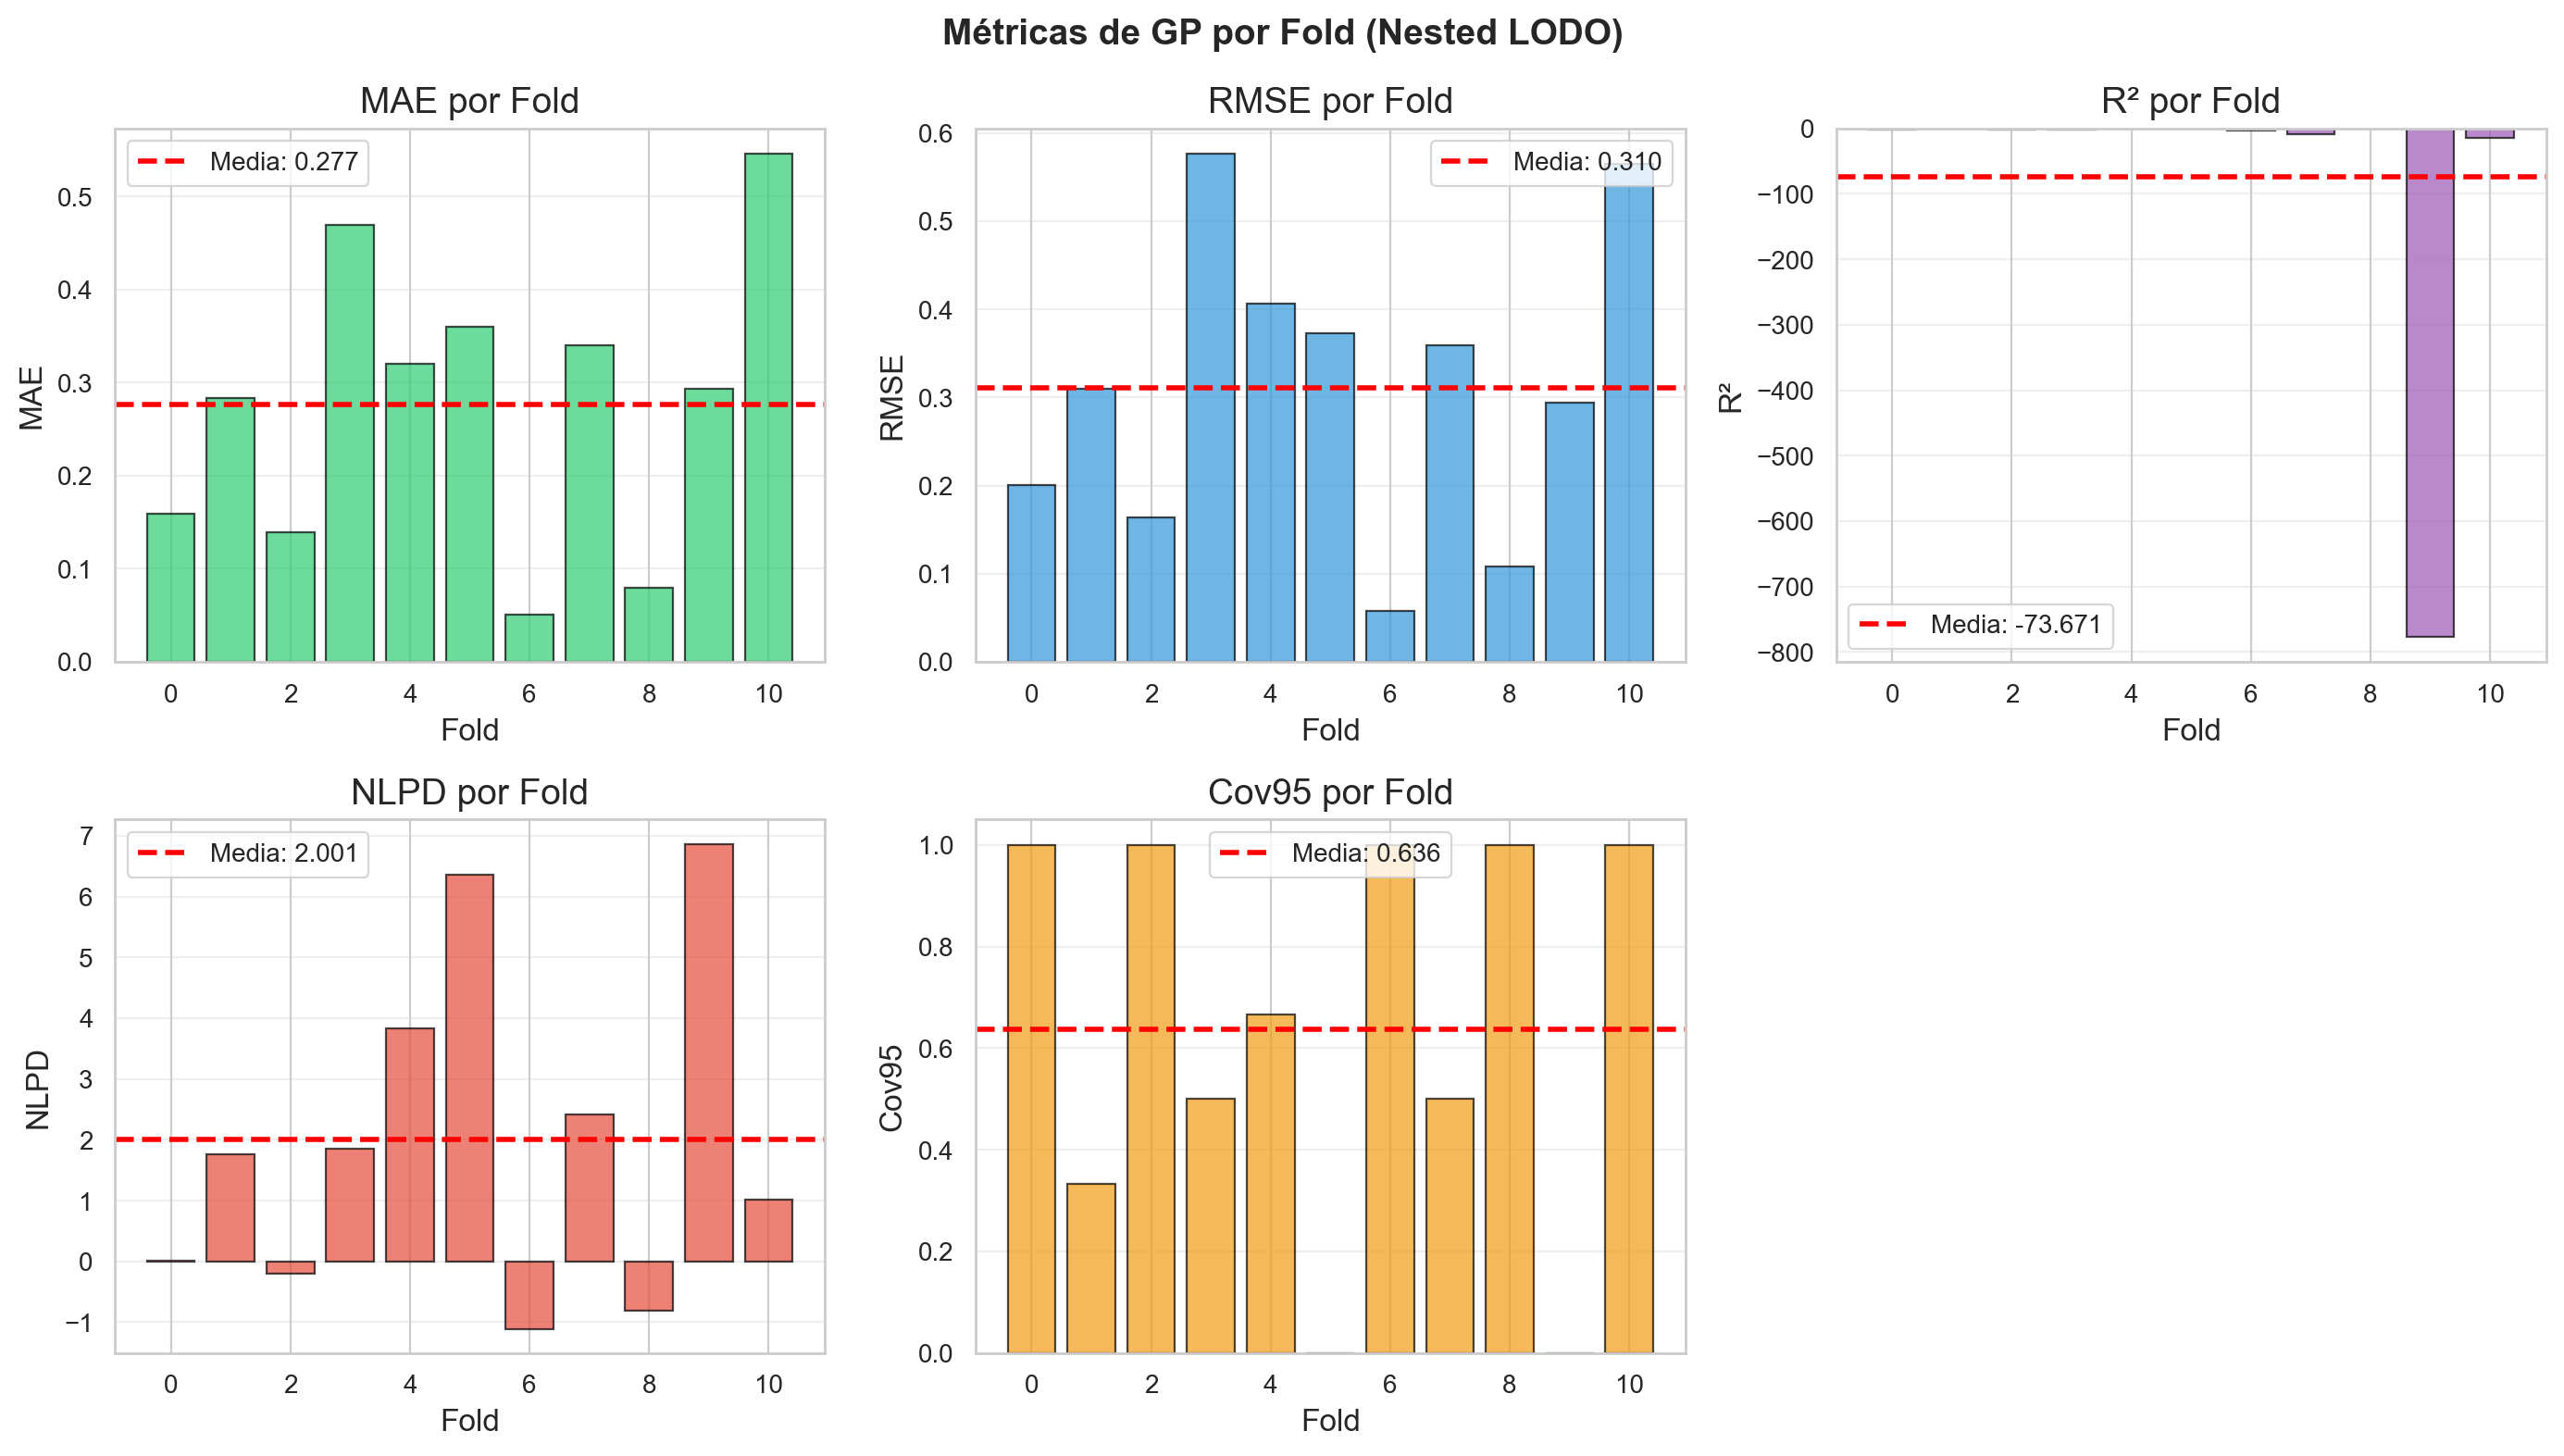

In [18]:
# Gráfico de métricas por fold
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

metrics_to_plot = ['MAE', 'RMSE', 'R²', 'NLPD', 'Cov95']
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12']

for ax, metric, color in zip(axes.flat, metrics_to_plot, colors):
    values = df_folds[metric].dropna()
    if len(values) > 0:
        ax.bar(range(len(values)), values, color=color, alpha=0.7, edgecolor='black')
        ax.axhline(values.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {values.mean():.3f}')
        ax.set_xlabel('Fold')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} por Fold')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

# Ocultar subplot vacío
axes[1, 2].axis('off')

plt.suptitle('Métricas de GP por Fold (Nested LODO)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Evaluación con Benchmarks

Ahora evaluamos el **mismo modelo** en funciones de benchmark sintéticas.

Esto permite:
- Validar el comportamiento del modelo en condiciones controladas
- Comparar con ground truth conocido
- Usar las **mismas métricas** que con datos reales

In [19]:
# Ver benchmarks disponibles
print("🧪 Benchmarks disponibles:")
print("=" * 50)
list_benchmarks()

🧪 Benchmarks disponibles:


['forrester',
 'branin',
 'sixhump',
 'goldstein',
 'hartmann3',
 'ishigami',
 'hartmann6',
 'borehole',
 'wingweight']

In [20]:
# Generar dataset sintético con Forrester (1D)
dataset_forrester = generate_benchmark_dataset(
    benchmark='forrester',
    n_train=50,
    n_test=100,
    sampler='sobol',
    noise='gaussian',
    noise_kwargs={'sigma': 0.1},
    seed=42
)

print(f"📊 Dataset Forrester generado:")
print(f"   Train: {dataset_forrester.X_train.shape}")
print(f"   Test: {dataset_forrester.X_test.shape}")
print(f"   Ruido: Gaussiano (σ=0.1)")

📊 Dataset Forrester generado:
   Train: (50, 1)
   Test: (100, 1)
   Ruido: Gaussiano (σ=0.1)


In [21]:
# Evaluar GP en el benchmark
gp_benchmark = GPSurrogateRegressor(alpha=0.1, normalize_y=True)

result_benchmark = evaluate_model_on_dataset(gp_benchmark, dataset_forrester)

# Convertir a dict para ver estructura
benchmark_dict = result_benchmark.to_dict()

print("📦 Estructura de resultado de benchmark:")
print(f"   Claves: {list(benchmark_dict.keys())}")

📦 Estructura de resultado de benchmark:
   Claves: ['benchmark', 'noise', 'model', 'metrics', 'fit_time_s', 'predict_time_s', 'model_params']


In [22]:
# Ver métricas del benchmark (MISMA estructura que datos reales)
print("📈 Métricas en Benchmark Forrester:")
print("=" * 50)

for metric_name, value in benchmark_dict['metrics'].items():
    if value is not None:
        print(f"   {metric_name:25s}: {value:.4f}")

📈 Métricas en Benchmark Forrester:
   n_samples                : 100.0000
   mae                      : 0.1600
   rmse                     : 0.2751
   r2                       : 0.9961
   max_error                : 1.2202
   nlpd                     : 0.6132
   coverage_50              : 0.9300
   coverage_90              : 1.0000
   coverage_95              : 1.0000
   mean_interval_width_95   : 2.7446
   median_interval_width_95 : 2.7099
   calibration_error_95     : 0.0500
   sharpness                : 0.7002


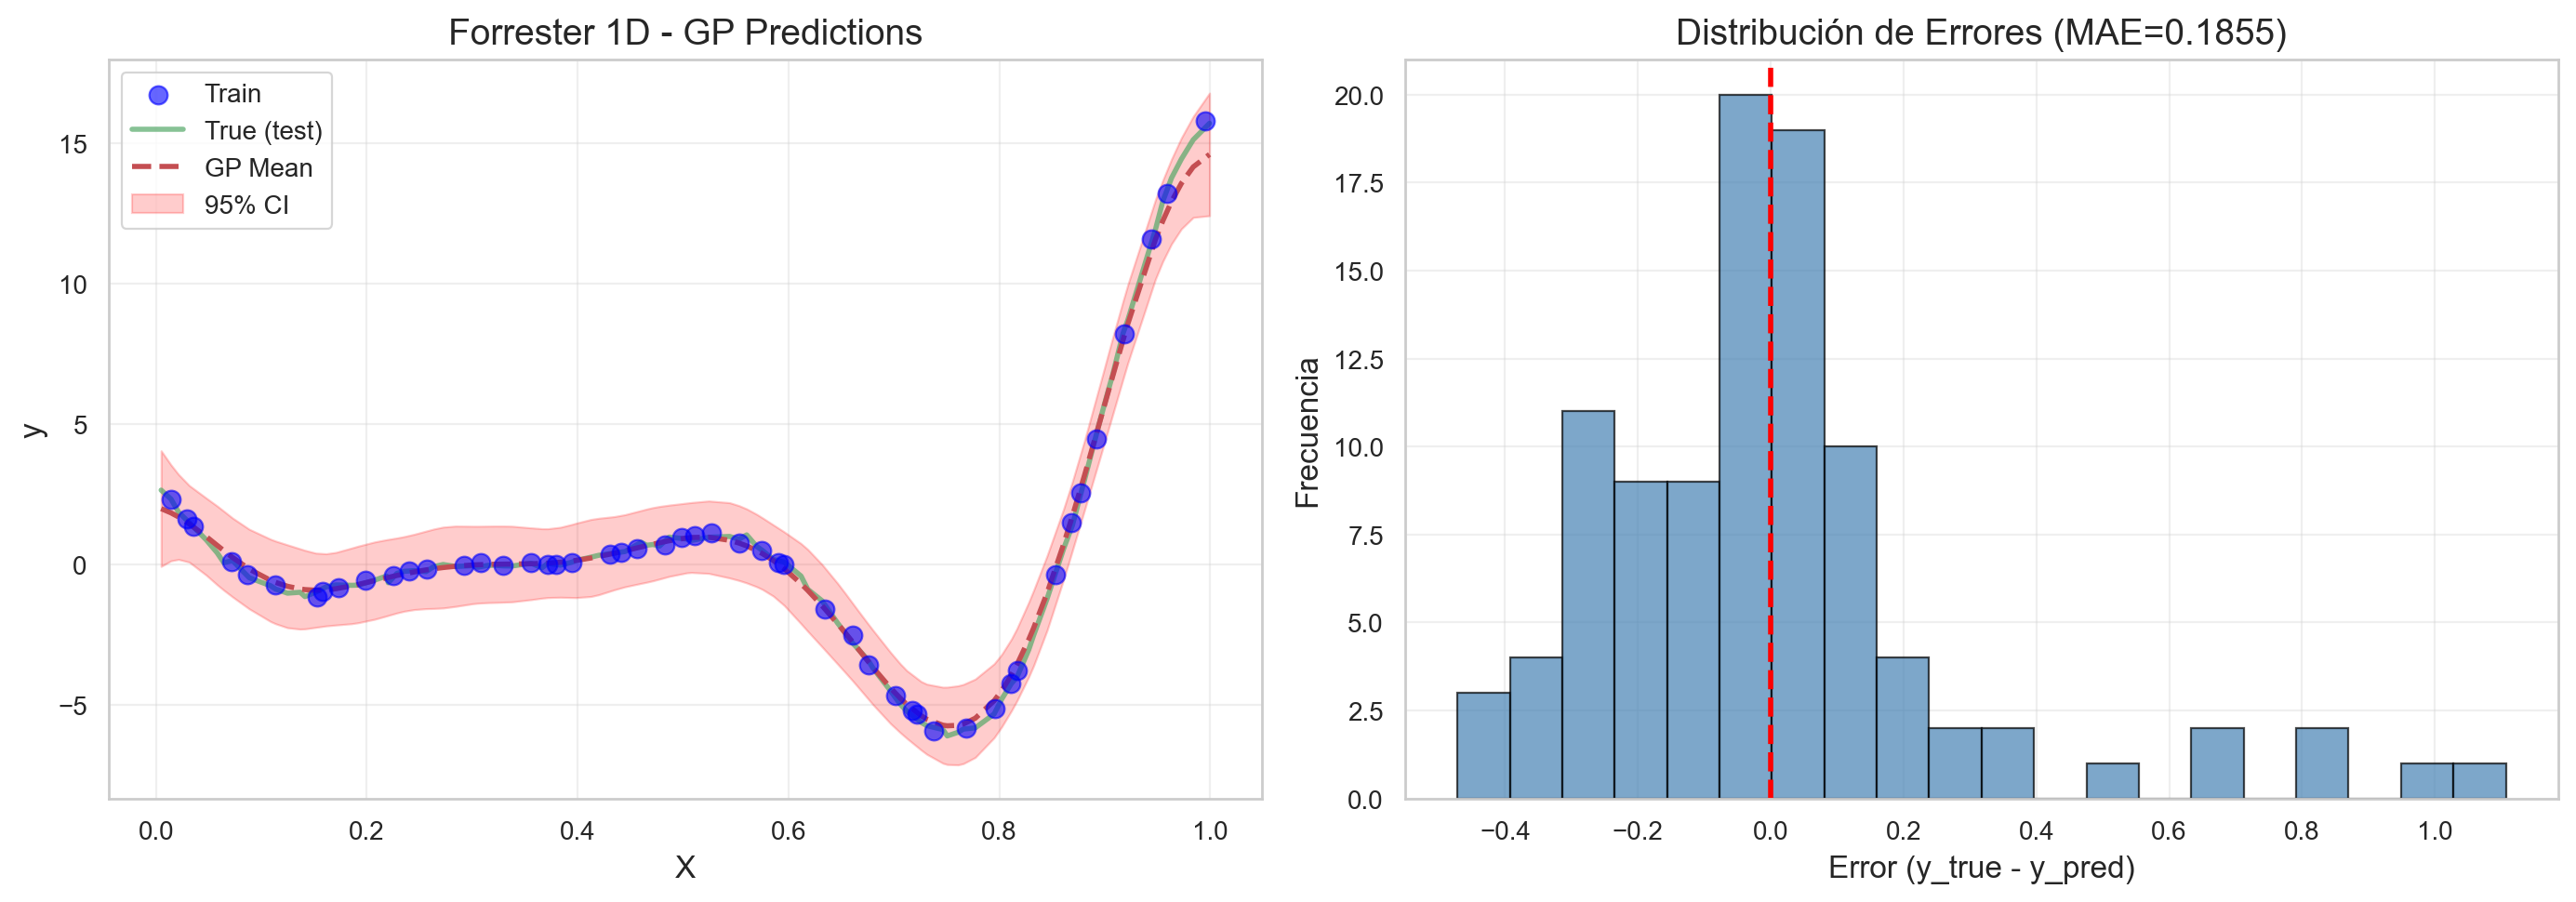

In [23]:
# Visualizar predicciones en Forrester
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fit y predict
gp_viz = GPSurrogateRegressor(alpha=0.1, normalize_y=True)
gp_viz.fit(dataset_forrester.X_train, dataset_forrester.y_train)
mean, std = gp_viz.predict_dist(dataset_forrester.X_test)

# Ordenar por X para visualización
sort_idx = np.argsort(dataset_forrester.X_test.ravel())
X_sorted = dataset_forrester.X_test.ravel()[sort_idx]
y_true_sorted = dataset_forrester.y_test[sort_idx]
mean_sorted = mean[sort_idx]
std_sorted = std[sort_idx]

# Plot 1: Predicciones vs Real
ax1 = axes[0]
ax1.scatter(dataset_forrester.X_train, dataset_forrester.y_train, 
            c='blue', s=50, alpha=0.6, label='Train', zorder=3)
ax1.plot(X_sorted, y_true_sorted, 'g-', linewidth=2, label='True (test)', alpha=0.7)
ax1.plot(X_sorted, mean_sorted, 'r--', linewidth=2, label='GP Mean')
ax1.fill_between(X_sorted, 
                  mean_sorted - 1.96*std_sorted, 
                  mean_sorted + 1.96*std_sorted,
                  alpha=0.2, color='red', label='95% CI')
ax1.set_xlabel('X')
ax1.set_ylabel('y')
ax1.set_title('Forrester 1D - GP Predictions')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Error distribution
ax2 = axes[1]
errors = y_true_sorted - mean_sorted
ax2.hist(errors, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Error (y_true - y_pred)')
ax2.set_ylabel('Frecuencia')
ax2.set_title(f'Distribución de Errores (MAE={np.abs(errors).mean():.4f})')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Métodos de evaluación en Benchmarks

Existen **3 formas** de evaluar modelos en benchmarks sintéticos, cada una con diferentes propósitos:

| Método | Función | Descripción | Uso típico |
|--------|---------|-------------|------------|
| **1. Train/Test Split** | `evaluate_model_on_dataset()` | División simple train/test | Evaluación rápida |
| **2. LODO CV** | `evaluate_model_with_lodo()` | Validación cruzada por grupos | Simular escenario real |
| **3. Nested LODO Tuning** | `nested_lodo_tuning_benchmark()` | Tuning + CV anidada | Comparación justa con datos reales |

### 6.1 Método 1: Train/Test Split Simple

Es el método más rápido. El modelo se entrena con todos los datos de entrenamiento y se evalúa en test.
Ya lo vimos arriba con `evaluate_model_on_dataset()`.

In [24]:
# MÉTODO 1: Train/Test Split Simple
# Ya ejecutado arriba, pero lo mostramos de nuevo para comparar

print("=" * 60)
print("MÉTODO 1: evaluate_model_on_dataset() - Train/Test Split")
print("=" * 60)

# Generar dataset SIN grupos (evaluación simple)
dataset_simple = generate_benchmark_dataset(
    benchmark='branin',
    n_train=80,
    n_test=100,
    noise='gaussian',
    noise_kwargs={'sigma': 5.0},  # Branin tiene valores más grandes
    seed=42
)

# Evaluar con train/test split
gp_method1 = GPSurrogateRegressor(alpha=0.1, normalize_y=True)
result_method1 = evaluate_model_on_dataset(gp_method1, dataset_simple)

print(f"\n📊 Dataset: {dataset_simple}")
print(f"\n📈 Métricas (Train/Test Split):")
for k, v in result_method1.metrics.to_dict().items():
    if v is not None:
        print(f"   {k:25s}: {v:.4f}")

MÉTODO 1: evaluate_model_on_dataset() - Train/Test Split

📊 Dataset: SyntheticDataset(benchmark='Branin2D', dim=2, n_train=80, n_test=100, noise='GaussianNoise')

📈 Métricas (Train/Test Split):
   n_samples                : 100.0000
   mae                      : 5.5316
   rmse                     : 7.7409
   r2                       : 0.9780
   max_error                : 39.6040
   nlpd                     : 3.4585
   coverage_50              : 0.7500
   coverage_90              : 0.9600
   coverage_95              : 0.9900
   mean_interval_width_95   : 39.3732
   median_interval_width_95 : 37.4576
   calibration_error_95     : 0.0400
   sharpness                : 10.0442


### 6.2 Método 2: LODO CV (Leave-One-Group-Out)

Simula el escenario de datos reales usando **grupos sintéticos**.
Permite obtener métricas más robustas con variabilidad entre folds.

Para usar este método, hay que generar el dataset con `n_groups > 1`.

In [25]:
# MÉTODO 2: LODO CV (Leave-One-Group-Out)
print("=" * 60)
print("MÉTODO 2: evaluate_model_with_lodo() - LODO CV")
print("=" * 60)

# Generar dataset CON GRUPOS (simula lotes/dietas)
dataset_with_groups = generate_benchmark_dataset(
    benchmark='branin',
    n_train=80,
    n_groups=5,  # ← Clave: asigna 5 grupos sintéticos
    noise='gaussian',
    noise_kwargs={'sigma': 5.0},
    seed=42
)

print(f"\n📊 Dataset: {dataset_with_groups}")
print(f"👥 Grupos únicos: {np.unique(dataset_with_groups.groups_train)}")

# Evaluar con LODO CV (sin tuning, hiperparámetros fijos)
gp_method2 = GPSurrogateRegressor(alpha=0.1, normalize_y=True)
result_method2 = evaluate_model_with_lodo(gp_method2, dataset_with_groups)

print(f"\n📈 Resultados LODO CV:")
print(f"   Número de folds: {result_method2['summary']['n_folds']}")
print(f"   Total muestras: {result_method2['summary']['total_samples']}")

MÉTODO 2: evaluate_model_with_lodo() - LODO CV

📊 Dataset: SyntheticDataset(benchmark='Branin2D', dim=2, n_train=80, n_test=200, noise='GaussianNoise')
👥 Grupos únicos: [0 1 2 3 4]

📈 Resultados LODO CV:
   Número de folds: 5
   Total muestras: 80


In [26]:
# Ver métricas MACRO y MICRO del método LODO
print("\n📊 Métricas MACRO (promedio por fold):")
print("-" * 50)
for metric_name in ['mae', 'rmse', 'r2', 'nlpd', 'coverage_95']:
    stats = result_method2['summary']['macro'].get(metric_name, {})
    if stats.get('mean') is not None:
        print(f"   {metric_name:20s}: {stats['mean']:.4f} ± {stats['std']:.4f}")

print("\n📊 Métricas MICRO (ponderadas por muestra):")
print("-" * 50)
for metric_name, value in result_method2['summary']['micro'].items():
    if value is not None and not metric_name.endswith('95'):
        print(f"   {metric_name:20s}: {value:.4f}")

# Mostrar resultados por fold
print("\n📋 Detalle por fold:")
fold_df = pd.DataFrame([
    {
        'Fold': f['fold_id'],
        'Group': f['group'],
        'n_test': f['n_test'],
        'MAE': f['metrics'].get('mae'),
        'RMSE': f['metrics'].get('rmse'),
        'Cov95': f['metrics'].get('coverage_95'),
    }
    for f in result_method2['folds']
])
fold_df


📊 Métricas MACRO (promedio por fold):
--------------------------------------------------
   mae                 : 8.6433 ± 2.6758
   rmse                : 14.4416 ± 8.0716
   r2                  : 0.9023 ± 0.0701
   nlpd                : 3.8981 ± 0.3512
   coverage_95         : 0.9667 ± 0.0422

📊 Métricas MICRO (ponderadas por muestra):
--------------------------------------------------
   mae                 : 8.8383
   rmse                : 17.4832
   coverage_50         : 0.7125
   coverage_90         : 0.9250

📋 Detalle por fold:


,Fold,Group,n_test,MAE,RMSE,Cov95
0,0,0,15,10.202440,17.724829,0.933333
1,1,1,11,7.752798,10.401951,1.000000
2,2,2,20,13.069851,28.797881,0.900000
3,3,3,21,6.108245,7.457274,1.000000
4,4,4,13,6.082937,7.825868,1.000000


### 6.3 Método 3: Nested LODO Tuning

El método más completo. Aplica **tuning de hiperparámetros** con validación cruzada anidada,
exactamente igual que con datos reales.

Esto permite:
- Comparación **justa** entre benchmarks y datos reales
- Selección de hiperparámetros **por fold** (sin data leakage)
- Estructura de resultados **idéntica** al tuning con datos reales

In [27]:
%%time

# MÉTODO 3: Nested LODO Tuning (igual que datos reales)
print("=" * 60)
print("MÉTODO 3: nested_lodo_tuning_benchmark() - Nested LODO Tuning")
print("=" * 60)

# Definir grilla de hiperparámetros
param_grid_benchmark = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'normalize_y': [True, False],
}

print(f"\n🔧 Grilla de hiperparámetros: {param_grid_benchmark}")
print(f"👥 Grupos en dataset: {np.unique(dataset_with_groups.groups_train)}")

# Ejecutar nested LODO tuning en benchmark
result_method3 = nested_lodo_tuning_benchmark(
    base_model=GPSurrogateRegressor(),
    param_grid=param_grid_benchmark,
    dataset=dataset_with_groups,
    scoring='mae',
    n_jobs=4,
)

print("\n✅ Nested LODO Tuning completado!")

MÉTODO 3: nested_lodo_tuning_benchmark() - Nested LODO Tuning

🔧 Grilla de hiperparámetros: {'alpha': [0.01, 0.1, 1.0, 10.0], 'normalize_y': [True, False]}
👥 Grupos en dataset: [0 1 2 3 4]

✅ Nested LODO Tuning completado!
CPU times: total: 109 ms
Wall time: 2.31 s


In [28]:
# Ver resultados del Nested LODO Tuning
print("📦 Estructura de resultados (igual que datos reales):")
print(f"   Claves: {list(result_method3.keys())}")

print("\n🔧 Hiperparámetros seleccionados por fold:")
for i, params in enumerate(result_method3['chosen_params']):
    print(f"   Fold {i}: {params}")

print("\n📊 Métricas MACRO:")
print("-" * 50)
for metric_name in ['mae', 'rmse', 'r2', 'nlpd', 'coverage_95']:
    stats = result_method3['summary']['macro'].get(metric_name, {})
    if stats.get('mean') is not None:
        print(f"   {metric_name:20s}: {stats['mean']:.4f} ± {stats['std']:.4f}")

📦 Estructura de resultados (igual que datos reales):
   Claves: ['folds', 'summary', 'chosen_params', 'benchmark', 'noise', 'n_groups']

🔧 Hiperparámetros seleccionados por fold:
   Fold 0: {'alpha': 0.01, 'normalize_y': True}
   Fold 1: {'alpha': 0.01, 'normalize_y': True}
   Fold 2: {'alpha': 0.01, 'normalize_y': True}
   Fold 3: {'alpha': 0.01, 'normalize_y': True}
   Fold 4: {'alpha': 0.01, 'normalize_y': True}

📊 Métricas MACRO:
--------------------------------------------------
   mae                 : 6.7539 ± 2.9351
   rmse                : 11.3639 ± 7.7276
   r2                  : 0.9355 ± 0.0561
   nlpd                : 3.5606 ± 0.4187
   coverage_95         : 0.9667 ± 0.0422


### 6.4 Comparación de los 3 métodos

Comparamos los resultados de los 3 métodos de evaluación en el mismo benchmark.

In [29]:
# Crear tabla comparativa de los 3 métodos
comparison_methods = pd.DataFrame([
    {
        'Método': '1. Train/Test Split',
        'Función': 'evaluate_model_on_dataset()',
        'MAE': result_method1.metrics.mae,
        'RMSE': result_method1.metrics.rmse,
        'R²': result_method1.metrics.r2,
        'Cov95': result_method1.metrics.coverage_95,
        'Con Tuning': '❌',
        'Grupos': '❌',
    },
    {
        'Método': '2. LODO CV',
        'Función': 'evaluate_model_with_lodo()',
        'MAE': result_method2['summary']['macro']['mae']['mean'],
        'RMSE': result_method2['summary']['macro']['rmse']['mean'],
        'R²': result_method2['summary']['macro']['r2']['mean'],
        'Cov95': result_method2['summary']['macro']['coverage_95']['mean'],
        'Con Tuning': '❌',
        'Grupos': '✅ (5)',
    },
    {
        'Método': '3. Nested LODO Tuning',
        'Función': 'nested_lodo_tuning_benchmark()',
        'MAE': result_method3['summary']['macro']['mae']['mean'],
        'RMSE': result_method3['summary']['macro']['rmse']['mean'],
        'R²': result_method3['summary']['macro']['r2']['mean'],
        'Cov95': result_method3['summary']['macro']['coverage_95']['mean'],
        'Con Tuning': '✅',
        'Grupos': '✅ (5)',
    },
])

print("📊 Comparación de los 3 métodos de evaluación en Branin (mismo ruido)")
print("=" * 80)
comparison_methods.set_index('Método')

📊 Comparación de los 3 métodos de evaluación en Branin (mismo ruido)


,Función,MAE,RMSE,R²,Cov95,Con Tuning,Grupos
Método,,,,,,,
1. Train/Test Split,evaluate_model_on_dataset(),5.531560,7.740915,0.977954,0.990000,❌,❌
2. LODO CV,evaluate_model_with_lodo(),8.643254,14.441560,0.902253,0.966667,❌,✅ (5)
3. Nested LODO Tuning,nested_lodo_tuning_benchmark(),6.753946,11.363939,0.935535,0.966667,✅,✅ (5)


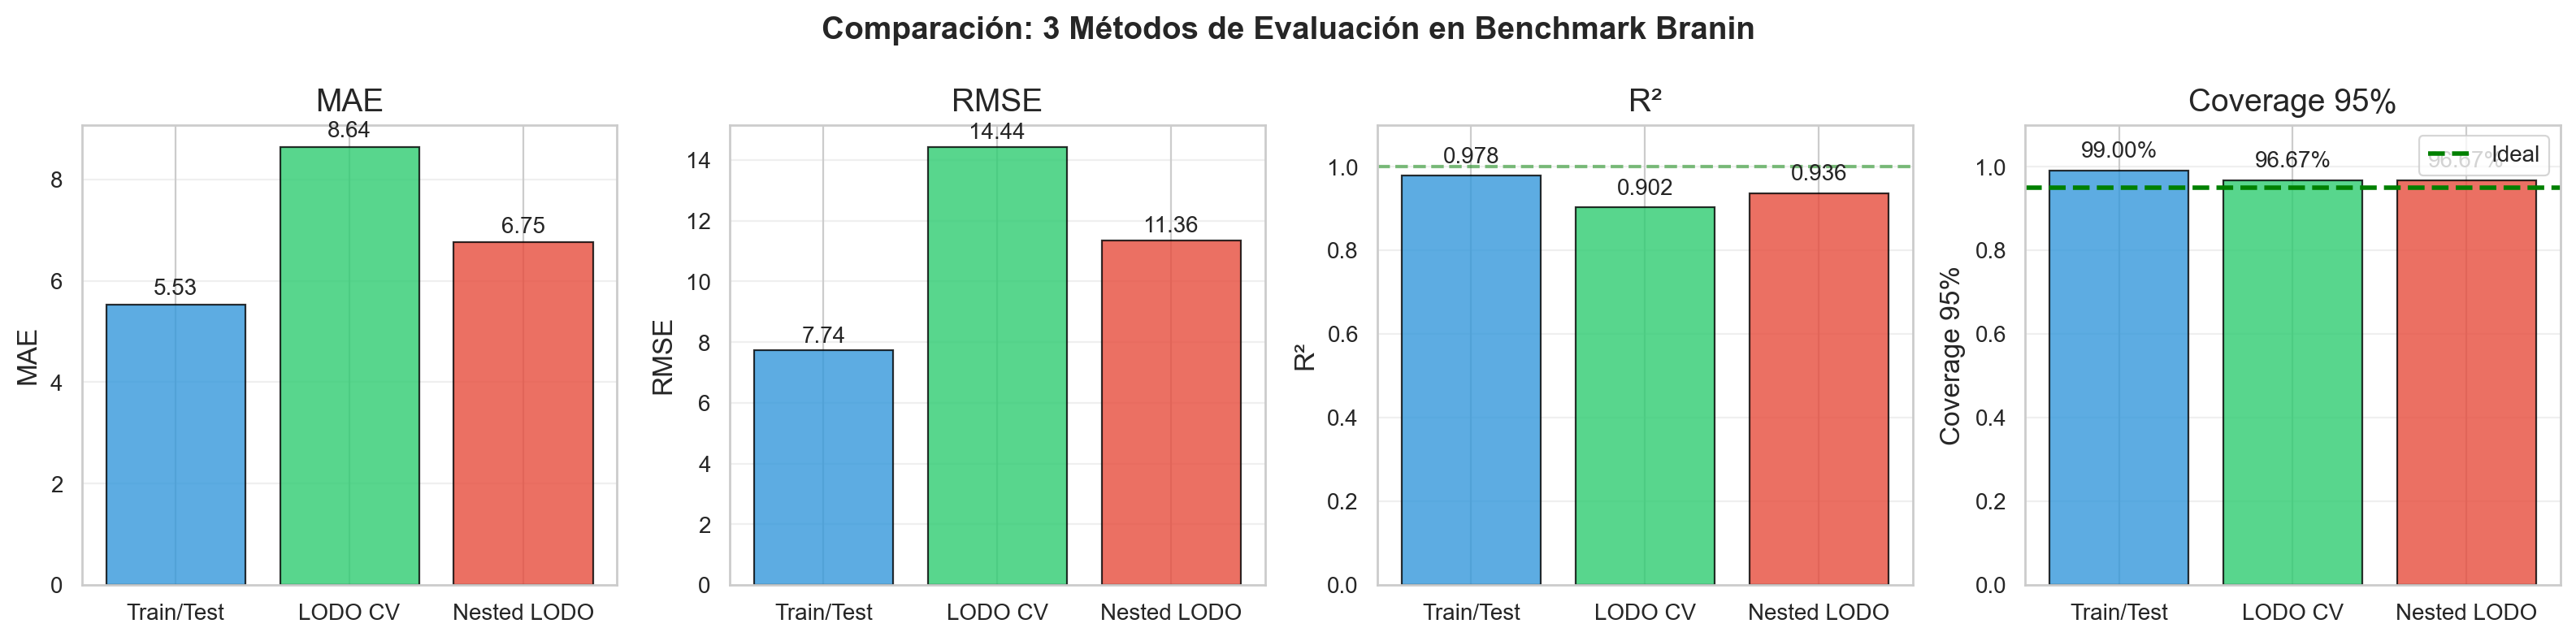


💡 Observaciones:
   - Train/Test: Resultado único, sin variabilidad
   - LODO CV: Proporciona variabilidad (std) entre folds
   - Nested LODO: Optimiza hiperparámetros, comparable con datos reales


In [30]:
# Visualización comparativa de los 3 métodos
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

methods = ['Train/Test', 'LODO CV', 'Nested LODO']
colors = ['#3498db', '#2ecc71', '#e74c3c']

# MAE
ax = axes[0]
mae_vals = [result_method1.metrics.mae, 
            result_method2['summary']['macro']['mae']['mean'],
            result_method3['summary']['macro']['mae']['mean']]
bars = ax.bar(methods, mae_vals, color=colors, edgecolor='black', alpha=0.8)
ax.set_ylabel('MAE')
ax.set_title('MAE')
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, mae_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            f'{val:.2f}', ha='center', va='bottom', fontsize=10)

# RMSE
ax = axes[1]
rmse_vals = [result_method1.metrics.rmse,
             result_method2['summary']['macro']['rmse']['mean'],
             result_method3['summary']['macro']['rmse']['mean']]
bars = ax.bar(methods, rmse_vals, color=colors, edgecolor='black', alpha=0.8)
ax.set_ylabel('RMSE')
ax.set_title('RMSE')
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, rmse_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            f'{val:.2f}', ha='center', va='bottom', fontsize=10)

# R²
ax = axes[2]
r2_vals = [result_method1.metrics.r2,
           result_method2['summary']['macro']['r2']['mean'],
           result_method3['summary']['macro']['r2']['mean']]
bars = ax.bar(methods, r2_vals, color=colors, edgecolor='black', alpha=0.8)
ax.set_ylabel('R²')
ax.set_title('R²')
ax.axhline(1.0, color='green', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, r2_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{val:.3f}', ha='center', va='bottom', fontsize=10)

# Coverage 95%
ax = axes[3]
cov_vals = [result_method1.metrics.coverage_95,
            result_method2['summary']['macro']['coverage_95']['mean'],
            result_method3['summary']['macro']['coverage_95']['mean']]
bars = ax.bar(methods, cov_vals, color=colors, edgecolor='black', alpha=0.8)
ax.set_ylabel('Coverage 95%')
ax.set_title('Coverage 95%')
ax.axhline(0.95, color='green', linestyle='--', linewidth=2, label='Ideal')
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, cov_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{val:.2%}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Comparación: 3 Métodos de Evaluación en Benchmark Branin', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Observaciones:")
print("   - Train/Test: Resultado único, sin variabilidad")
print("   - LODO CV: Proporciona variabilidad (std) entre folds")
print("   - Nested LODO: Optimiza hiperparámetros, comparable con datos reales")

## 7. Comparación unificada

Ahora demostramos que las métricas tienen **la misma estructura** y pueden
combinarse en análisis unificados entre **datos reales** y **benchmarks**.

In [31]:
# Comparar estructura de métricas: Real vs Benchmark
print("🔄 Comparación de estructura de métricas")
print("=" * 60)

# Métricas de datos reales (de un fold)
real_metrics = results_gp['folds'][0]['metrics']

# Métricas de benchmark
benchmark_metrics = benchmark_dict['metrics']

print(f"\n📊 Claves en datos REALES ({len(real_metrics)}):")
print(f"   {sorted([k for k in real_metrics.keys() if not k.startswith('_')])}")

print(f"\n📊 Claves en BENCHMARK ({len(benchmark_metrics)}):")
print(f"   {sorted(benchmark_metrics.keys())}")

# Métricas comunes
common = set(k for k in real_metrics.keys() if not k.startswith('_')) & set(benchmark_metrics.keys())
print(f"\n✅ Métricas COMUNES ({len(common)}): {sorted(common)}")

🔄 Comparación de estructura de métricas

📊 Claves en datos REALES (18):
   ['calibration_error_95', 'coverage95', 'coverage_50', 'coverage_90', 'coverage_95', 'mae', 'max_error', 'mean_interval_width_95', 'median_interval_width_95', 'n_samples', 'nlpd', 'r2', 'rmse', 'sharpness']

📊 Claves en BENCHMARK (13):
   ['calibration_error_95', 'coverage_50', 'coverage_90', 'coverage_95', 'mae', 'max_error', 'mean_interval_width_95', 'median_interval_width_95', 'n_samples', 'nlpd', 'r2', 'rmse', 'sharpness']

✅ Métricas COMUNES (13): ['calibration_error_95', 'coverage_50', 'coverage_90', 'coverage_95', 'mae', 'max_error', 'mean_interval_width_95', 'median_interval_width_95', 'n_samples', 'nlpd', 'r2', 'rmse', 'sharpness']


In [32]:
# Crear DataFrame unificado para comparación
comparison_data = []

# Añadir resultados de datos reales (promedio)
for metric in ['mae', 'rmse', 'r2', 'nlpd', 'coverage_95', 'calibration_error_95']:
    real_val = summary_gp['macro'].get(metric, {}).get('mean')
    bench_val = benchmark_metrics.get(metric)
    
    if real_val is not None or bench_val is not None:
        comparison_data.append({
            'Métrica': metric,
            'Datos Reales (GP)': real_val,
            'Benchmark Forrester (GP)': bench_val,
        })

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.set_index('Métrica')

print("📊 Comparación de métricas GP: Datos Reales vs Benchmark")
print("=" * 60)
df_comparison

📊 Comparación de métricas GP: Datos Reales vs Benchmark


,Datos Reales (GP),Benchmark Forrester (GP)
Métrica,,
mae,0.276520,0.160019
rmse,0.310400,0.275061
r2,-73.671093,0.996116
nlpd,2.000572,0.613212
coverage_95,0.636364,1.000000
calibration_error_95,0.359091,0.050000


In [38]:
# Evaluación rápida en múltiples benchmarks
print("🚀 Evaluación rápida en múltiples benchmarks...")

quick_results = run_quick_benchmark(
    models={'gp': GPSurrogateRegressor(alpha=0.1, normalize_y=True)},
    benchmarks=['forrester', 'branin'],
    noise_sigma=0.1,
    n_train=50,
    n_test=100,
    seed=42
)

# Mostrar resumen
df_quick = quick_results.get_summary_df()
print("\n📋 Resumen de evaluación rápida:")
df_quick[['benchmark', 'noise', 'mae', 'rmse', 'r2', 'nlpd', 'coverage_95']]

🚀 Evaluación rápida en múltiples benchmarks...
QUICK BENCHMARK EVALUATION
Benchmarks: ['forrester', 'branin']
Models: ['gp']
Noise configs: [{'type': 'none'}, {'type': 'gaussian', 'sigma': 0.1}]
[1/4] forrester/none/gp... RMSE=0.2619, R²=0.996
[2/4] forrester/gaussian_s0.1/gp... RMSE=0.2270, R²=0.997
[3/4] branin/none/gp... RMSE=10.9333, R²=0.955
[4/4] branin/gaussian_s0.1/gp... RMSE=16.3111, R²=0.911

MODEL RANKING (by RMSE)
                      avg_rank  rmse_mean  rmse_std
model                                              
GPSurrogateRegressor       1.0     6.9333    8.0296

MODEL RANKING (by R²)
                      avg_rank  r2_mean  r2_std
model                                          
GPSurrogateRegressor       1.0    0.965   0.041

📋 Resumen de evaluación rápida:


,benchmark,noise,mae,rmse,r2,nlpd,coverage_95
0,Forrester1D,NoNoise,0.146788,0.261943,0.996478,0.610087,1.00
1,Forrester1D,GaussianNoise,0.142748,0.226971,0.997240,0.653943,1.00
2,Branin2D,NoNoise,7.294982,10.933282,0.955300,3.707563,0.96
3,Branin2D,GaussianNoise,7.409460,16.311081,0.910878,3.714883,0.99


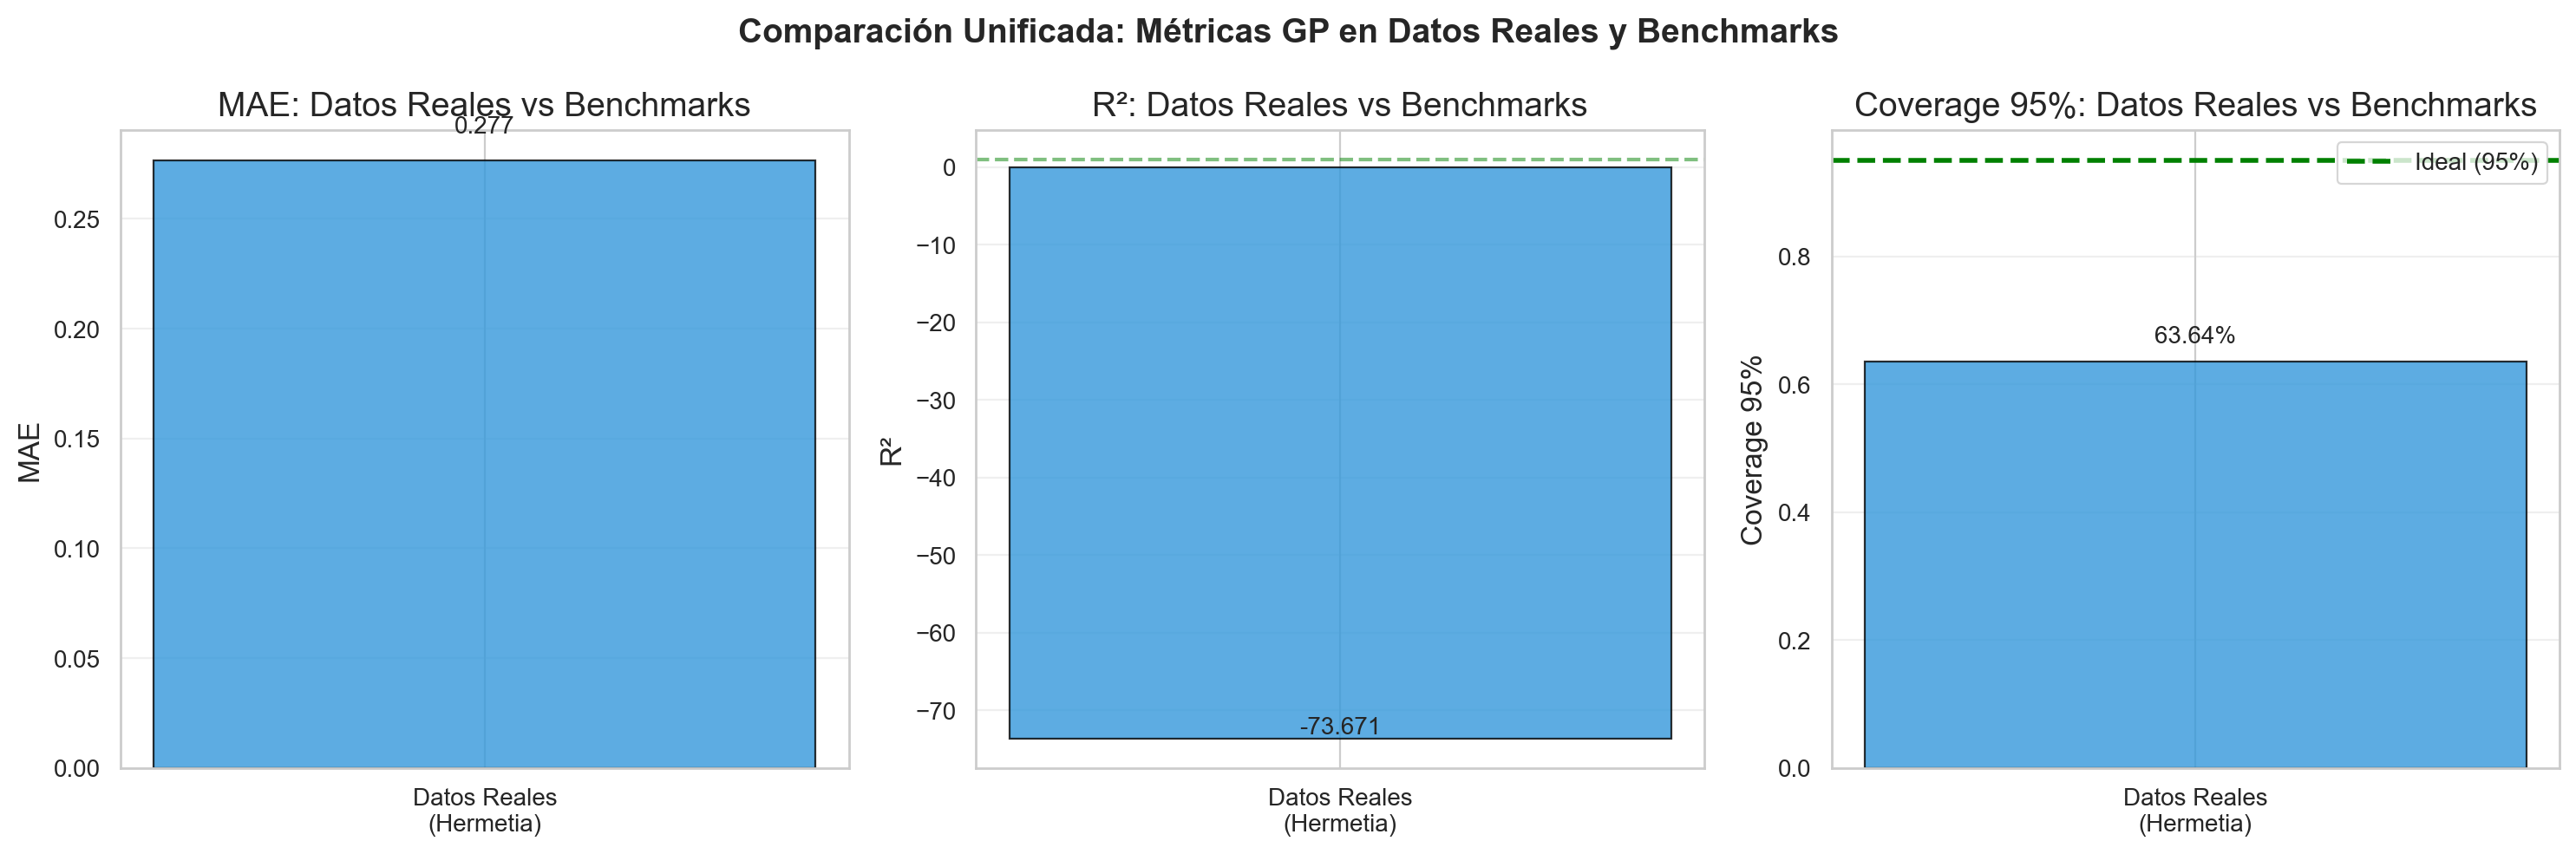

In [42]:
# Visualización comparativa final
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. MAE comparison
ax1 = axes[0]
labels = ['Datos Reales\n(Hermetia)', 'Forrester\n(sin ruido)', 'Forrester\n(σ=0.1)', 'Branin\n(sin ruido)']
mae_values = [
    summary_gp['macro']['mae']['mean'],
    df_quick[df_quick['benchmark']=='forrester'][df_quick['noise']=='none']['mae'].values[0] if len(df_quick[df_quick['benchmark']=='forrester'][df_quick['noise']=='none']) > 0 else np.nan,
    df_quick[(df_quick['benchmark']=='forrester') & (df_quick['noise']!='none')]['mae'].values[0] if len(df_quick[(df_quick['benchmark']=='forrester') & (df_quick['noise']!='none')]) > 0 else np.nan,
    df_quick[df_quick['benchmark']=='branin'][df_quick['noise']=='none']['mae'].values[0] if len(df_quick[df_quick['benchmark']=='branin'][df_quick['noise']=='none']) > 0 else np.nan,
]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']
bars = ax1.bar(labels, mae_values, color=colors, edgecolor='black', alpha=0.8)
ax1.set_ylabel('MAE')
ax1.set_title('MAE: Datos Reales vs Benchmarks')
ax1.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, mae_values):
    if not np.isnan(val):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{val:.3f}', ha='center', va='bottom', fontsize=10)

# 2. R² comparison
ax2 = axes[1]
r2_values = [
    summary_gp['macro']['r2']['mean'] if summary_gp['macro']['r2']['mean'] else np.nan,
    df_quick[df_quick['benchmark']=='forrester'][df_quick['noise']=='none']['r2'].values[0] if len(df_quick[df_quick['benchmark']=='forrester'][df_quick['noise']=='none']) > 0 else np.nan,
    df_quick[(df_quick['benchmark']=='forrester') & (df_quick['noise']!='none')]['r2'].values[0] if len(df_quick[(df_quick['benchmark']=='forrester') & (df_quick['noise']!='none')]) > 0 else np.nan,
    df_quick[df_quick['benchmark']=='branin'][df_quick['noise']=='none']['r2'].values[0] if len(df_quick[df_quick['benchmark']=='branin'][df_quick['noise']=='none']) > 0 else np.nan,
]
bars = ax2.bar(labels, r2_values, color=colors, edgecolor='black', alpha=0.8)
ax2.set_ylabel('R²')
ax2.set_title('R²: Datos Reales vs Benchmarks')
ax2.axhline(1.0, color='green', linestyle='--', alpha=0.5, label='Perfecto')
ax2.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, r2_values):
    if not np.isnan(val):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{val:.3f}', ha='center', va='bottom', fontsize=10)

# 3. Coverage 95% comparison
ax3 = axes[2]
cov_values = [
    summary_gp['macro']['coverage_95']['mean'] if summary_gp['macro'].get('coverage_95', {}).get('mean') else np.nan,
    df_quick[df_quick['benchmark']=='forrester'][df_quick['noise']=='none']['coverage_95'].values[0] if len(df_quick[df_quick['benchmark']=='forrester'][df_quick['noise']=='none']) > 0 else np.nan,
    df_quick[(df_quick['benchmark']=='forrester') & (df_quick['noise']!='none')]['coverage_95'].values[0] if len(df_quick[(df_quick['benchmark']=='forrester') & (df_quick['noise']!='none')]) > 0 else np.nan,
    df_quick[df_quick['benchmark']=='branin'][df_quick['noise']=='none']['coverage_95'].values[0] if len(df_quick[df_quick['benchmark']=='branin'][df_quick['noise']=='none']) > 0 else np.nan,
]
bars = ax3.bar(labels, cov_values, color=colors, edgecolor='black', alpha=0.8)
ax3.set_ylabel('Coverage 95%')
ax3.set_title('Coverage 95%: Datos Reales vs Benchmarks')
ax3.axhline(0.95, color='green', linestyle='--', linewidth=2, label='Ideal (95%)')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, cov_values):
    if not np.isnan(val):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{val:.2%}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Comparación Unificada: Métricas GP en Datos Reales y Benchmarks', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 📝 Resumen

### Estructura de métricas unificada

Tanto los **datos reales** como los **benchmarks sintéticos** producen métricas con la misma estructura:

| Métrica | Descripción | Ideal |
|---------|-------------|-------|
| `mae` | Mean Absolute Error | ↓ Menor |
| `rmse` | Root Mean Squared Error | ↓ Menor |
| `r2` | Coeficiente de determinación | ↑ Cercano a 1 |
| `nlpd` | Negative Log Predictive Density | ↓ Menor |
| `coverage_95` | Cobertura del intervalo 95% | ≈ 0.95 |
| `calibration_error_95` | Error de calibración | ↓ Cercano a 0 |
| `sharpness` | Nitidez (std promedio) | ↓ Menor (si bien calibrado) |

### Ventajas de esta unificación

1. **Comparabilidad directa** entre datasets reales y sintéticos
2. **Código reutilizable** para visualización y análisis
3. **Validación cruzada** del modelo en condiciones controladas
4. **Diagnóstico** de problemas de calibración de incertidumbre

In [35]:
# Guardar resultados (opcional)
import json
from datetime import datetime

# Preparar datos para guardar
output = {
    'timestamp': datetime.now().isoformat(),
    'model': 'GP',
    'real_data': {
        'dataset': 'productivity_hermetia',
        'target': TARGET_COL,
        'summary': results_gp['summary'],
    },
    'benchmark': {
        'name': 'forrester',
        'metrics': benchmark_dict['metrics'],
    }
}

# Descomentar para guardar
# with open('../outputs/logs/unified_evaluation_demo.json', 'w') as f:
#     json.dump(output, f, indent=2, default=str)
# print("✅ Resultados guardados")

print("✅ Notebook completado exitosamente!")

✅ Notebook completado exitosamente!
